In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PTHREADS_CSV = os.path.join(os.getcwd(), '1_1_polynomial_multiplication', 'results_1.1.csv')
OPENMP_CSV = os.path.join(os.getcwd(), '2_1_polynomial_multiplication', 'results_2.1.csv')
MPI_CSV = os.path.join(os.getcwd(), '3_1_polynomial_multiplication', 'results_3.1.csv')
PLOTS_DIR = os.path.join(os.getcwd(), 'comparison_plots_for_3_1')
os.makedirs(PLOTS_DIR, exist_ok=True)

pthreads = pd.read_csv(PTHREADS_CSV)
openmp = pd.read_csv(OPENMP_CSV)
mpi = pd.read_csv(MPI_CSV)

if 'user' not in pthreads.columns:
    pthreads['user'] = 'unknown'
if 'user' not in openmp.columns:
    openmp['user'] = 'unknown'
if 'user' not in mpi.columns:
    mpi['user'] = 'unknown'

pthreads['degree'] = pthreads['degree'].astype(int)
openmp['degree'] = openmp['degree'].astype(int)
mpi['degree'] = mpi['degree'].astype(int)

# Adjust total times to exclude allocation, initialization, verification and cleanup
# MPI timing excludes all these, so we subtract them from Pthreads/OpenMP for fair comparison
pthreads['time_total_adjusted'] = (pthreads['time_total'] - pthreads['time_alloc'] - 
                                     pthreads['time_init'] - pthreads['time_verify'] - 
                                     pthreads['time_cleanup'])
openmp['time_total_adjusted'] = (openmp['time_total'] - openmp['time_alloc'] - 
                                   openmp['time_init'] - openmp['time_verify'] - 
                                   openmp['time_cleanup'])
mpi['time_total_adjusted'] = mpi['time_total']  # MPI already excludes alloc/init/verify/cleanup

def threads_to_int(x):
    if str(x).lower() == 'sequential':
        return -1
    try:
        return int(x)
    except Exception:
        return 1

pthreads['threads_int'] = pthreads['threads'].apply(threads_to_int)
openmp['threads_int'] = openmp['threads'].apply(threads_to_int)
mpi['procs_int'] = mpi['threads'].apply(threads_to_int)

print('Loaded datasets:')
print(f'Pthreads: {len(pthreads)} rows')
print(f'OpenMP: {len(openmp)} rows')
print(f'MPI: {len(mpi)} rows')
print('\nAdjusted times to exclude alloc/init/verify/cleanup for fair comparison')

Loaded datasets:
Pthreads: 360 rows
OpenMP: 360 rows
MPI: 360 rows

Adjusted times to exclude alloc/init/verify/cleanup for fair comparison


In [15]:
def compute_mpi_vs_openmp_speedup(mpi_df, openmp_df, user):
    mpi_user = mpi_df[mpi_df['user'] == user].copy()
    openmp_user = openmp_df[openmp_df['user'] == user].copy()
    
    if mpi_user.empty or openmp_user.empty:
        return None
    
    mpi_user = mpi_user[mpi_user['procs_int'] >= 0]
    openmp_user = openmp_user[openmp_user['threads_int'] >= 0]
    
    merged = mpi_user.merge(
        openmp_user,
        left_on=['degree', 'procs_int'],
        right_on=['degree', 'threads_int'],
        suffixes=('_mpi', '_openmp')
    )
    
    # Use adjusted times for fair comparison (excluding alloc/init)
    merged['speedup'] = merged['time_total_adjusted_openmp'] / merged['time_total_adjusted_mpi']
    
    stats = merged.groupby(['degree', 'procs_int'])['speedup'].agg(['mean', 'std']).reset_index()
    stats['std'] = stats['std'].fillna(0)
    
    return stats

def compute_mpi_vs_pthreads_speedup(mpi_df, pthreads_df, user):
    mpi_user = mpi_df[mpi_df['user'] == user].copy()
    pthreads_user = pthreads_df[pthreads_df['user'] == user].copy()
    
    if mpi_user.empty or pthreads_user.empty:
        return None
    
    mpi_user = mpi_user[mpi_user['procs_int'] >= 0]
    pthreads_user = pthreads_user[pthreads_user['threads_int'] >= 0]
    
    merged = mpi_user.merge(
        pthreads_user,
        left_on=['degree', 'procs_int'],
        right_on=['degree', 'threads_int'],
        suffixes=('_mpi', '_pthreads')
    )
    
    # Use adjusted times for fair comparison (excluding alloc/init)
    merged['speedup'] = merged['time_total_adjusted_pthreads'] / merged['time_total_adjusted_mpi']
    
    stats = merged.groupby(['degree', 'procs_int'])['speedup'].agg(['mean', 'std']).reset_index()
    stats['std'] = stats['std'].fillna(0)
    
    return stats

In [16]:
def plot_mpi_comparisons(mpi_df, openmp_df, pthreads_df, user):
    stats_openmp = compute_mpi_vs_openmp_speedup(mpi_df, openmp_df, user)
    stats_pthreads = compute_mpi_vs_pthreads_speedup(mpi_df, pthreads_df, user)
    
    if stats_openmp is None or stats_openmp.empty:
        print(f'No data for MPI vs OpenMP comparison for user: {user}')
        return
    if stats_pthreads is None or stats_pthreads.empty:
        print(f'No data for MPI vs Pthreads comparison for user: {user}')
        return
    
    degrees = sorted(set(stats_openmp['degree'].unique()) & set(stats_pthreads['degree'].unique()))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(degrees)))
    
    jitter_amount = 0.3
    offsets = np.linspace(-jitter_amount * (len(degrees)-1)/2, 
                          jitter_amount * (len(degrees)-1)/2, 
                          len(degrees))
    
    # Subplot 1: MPI vs OpenMP
    for idx, degree in enumerate(degrees):
        degree_stats = stats_openmp[stats_openmp['degree'] == degree]
        
        procs = degree_stats['procs_int'].values + offsets[idx]
        
        ax1.errorbar(procs, degree_stats['mean'].values, 
                   yerr=degree_stats['std'].values,
                   marker='o', capsize=5, linewidth=2, markersize=8,
                   color=colors[idx], label=f'degree={degree}')
    
    ax1.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='No speedup (1.0x)')
    
    procs_all = sorted(stats_openmp['procs_int'].unique())
    procs_labels = ['seq' if p == -1 else str(p) for p in procs_all]
    
    ax1.set_xlabel('Processes', fontsize=12)
    ax1.set_ylabel('Speedup (OpenMP / MPI)', fontsize=12)
    ax1.set_title(f'MPI vs OpenMP Performance - User: {user}', fontsize=14)
    ax1.set_xticks(procs_all)
    ax1.set_xticklabels(procs_labels)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Subplot 2: MPI vs Pthreads
    for idx, degree in enumerate(degrees):
        degree_stats = stats_pthreads[stats_pthreads['degree'] == degree]
        
        procs = degree_stats['procs_int'].values + offsets[idx]
        
        ax2.errorbar(procs, degree_stats['mean'].values, 
                   yerr=degree_stats['std'].values,
                   marker='o', capsize=5, linewidth=2, markersize=8,
                   color=colors[idx], label=f'degree={degree}')
    
    ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='No speedup (1.0x)')
    
    procs_all = sorted(stats_pthreads['procs_int'].unique())
    procs_labels = ['seq' if p == -1 else str(p) for p in procs_all]
    
    ax2.set_xlabel('Processes', fontsize=12)
    ax2.set_ylabel('Speedup (Pthreads / MPI)', fontsize=12)
    ax2.set_title(f'MPI vs Pthreads Performance - User: {user}', fontsize=14)
    ax2.set_xticks(procs_all)
    ax2.set_xticklabels(procs_labels)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    
    output_file = os.path.join(PLOTS_DIR, f'mpi_comparison_{user}.png')
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f'Saved: {output_file}')
    plt.show()

Found 3 common users: ['ea24205', 'marr', 'phoebus']

Processing user: ea24205
Saved: /home/marr/threads/Thread-Experiments/comparison_plots_for_3_1/mpi_comparison_ea24205.png


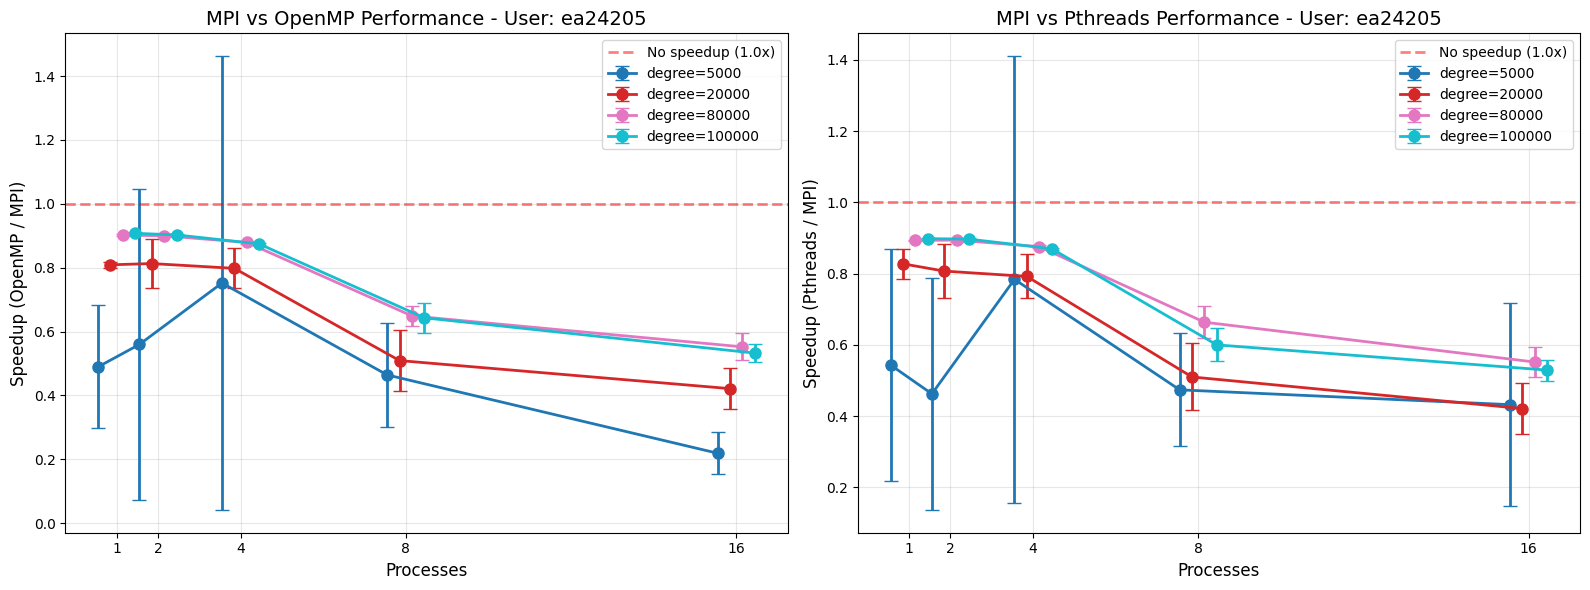

Processing user: marr
Saved: /home/marr/threads/Thread-Experiments/comparison_plots_for_3_1/mpi_comparison_marr.png


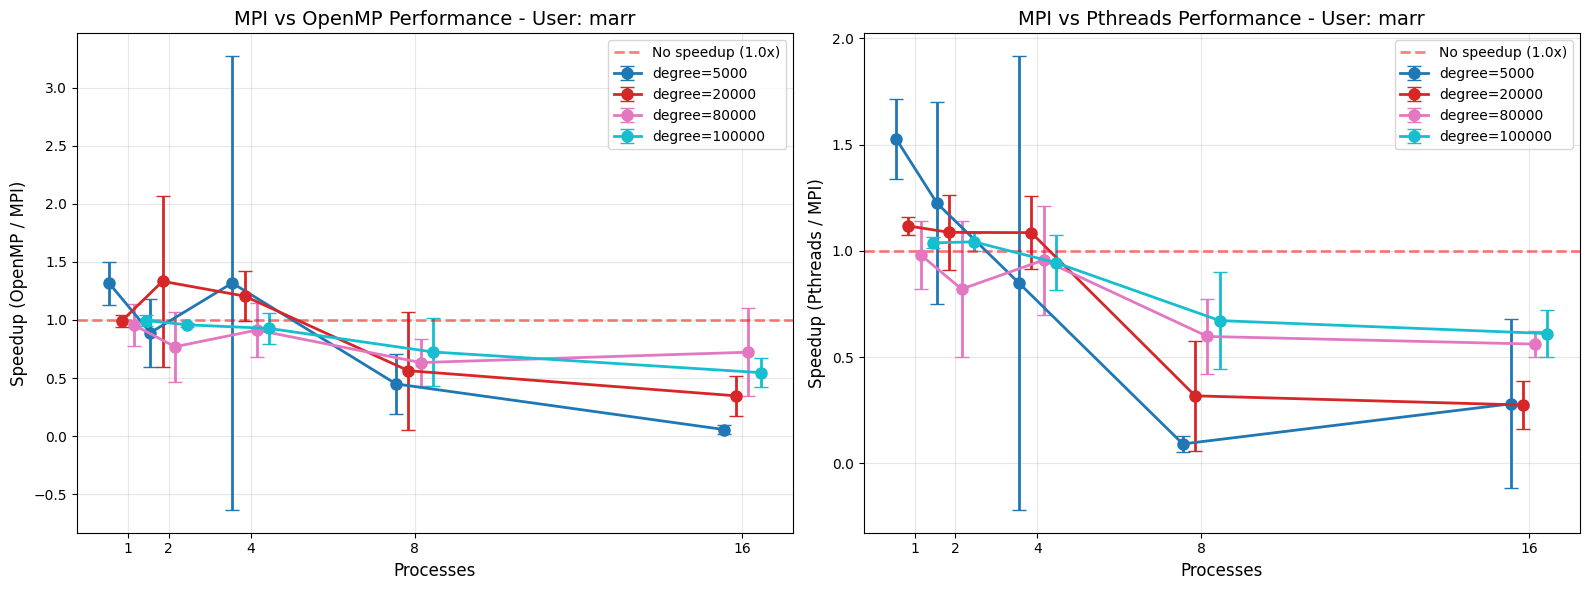

Processing user: phoebus
Saved: /home/marr/threads/Thread-Experiments/comparison_plots_for_3_1/mpi_comparison_phoebus.png


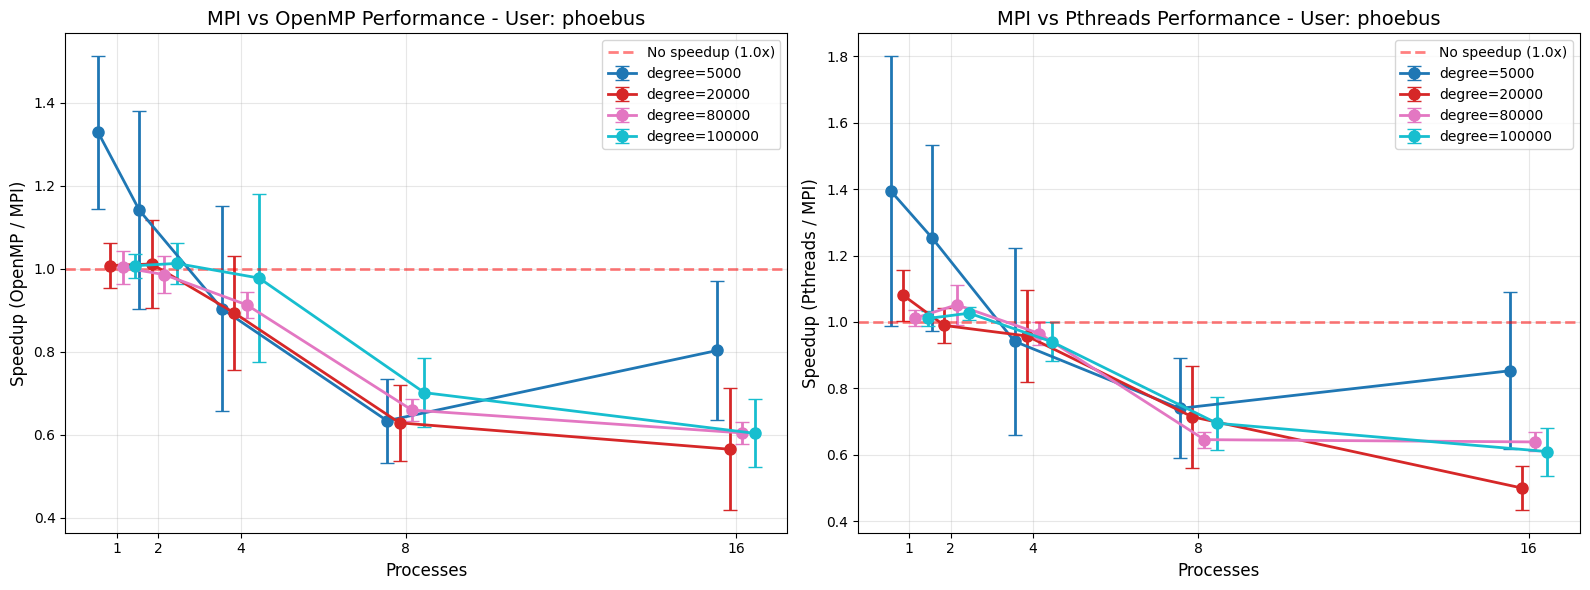

In [17]:
users = set(pthreads['user'].unique()) & set(openmp['user'].unique()) & set(mpi['user'].unique())
users = sorted(users)

print(f'Found {len(users)} common users: {users}\n')

for user in users:
    print(f'Processing user: {user}')
    plot_mpi_comparisons(mpi, openmp, pthreads, user)